In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
movies = "movies.csv"
ratings = "ratings.csv"

In [3]:
# Importing dataset
df_movies = pd.read_csv(movies, usecols=['movieId', 'title'], dtype={'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})


In [21]:
df_movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [22]:
df_ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [17]:
# Create pivot table
movie_user = df_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
matrix_movies_users = csr_matrix(movie_user.values)



In [23]:
movie_user

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
matrix_movies_users

<9724x610 sparse matrix of type '<class 'numpy.float32'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [18]:
# Convert to dense matrix
dense_matrix_movies_users = matrix_movies_users.todense()


In [19]:
# Building model
knn = NearestNeighbors(n_neighbors=20, metric='correlation', algorithm='brute')

def recommender(movieName, data, model, n_recs):
    model.fit(data)
    index_of_movie = df_movies[df_movies['title'].str.contains(movieName, case=False)].index[0]
    print('Movie selected:', df_movies['title'][index_of_movie], ' Index:', index_of_movie)
    print('Searching for recommendations....')
    distances, indices = model.kneighbors(data[index_of_movie], n_neighbors=n_recs)
    for i, index in enumerate(indices):
        movie_title = df_movies['title'][index]
        similarity_score = 1 - distances[i]  # Convert distances to similarity scores using 1 - distance
        movie_scores = pd.DataFrame({'Title': movie_title, 'Similarity Score': similarity_score})
        movie_scores = movie_scores[movie_scores['Title'] != movieName]  # Exclude the selected movie from recommendations
        print(movie_scores)

        # Visualization
        plt.figure(figsize=(8, 6))
        sns.barplot(x='Similarity Score', y='Title', data=movie_scores, palette='viridis')
        plt.title('Similar Movies based on Pearson Correlation')
        plt.xlabel('Similarity Score')
        plt.ylabel('Movie Title')
        plt.show()




C:\Users\Ankita Markad.DESKTOP-DO359FP\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Ankita Markad.DESKTOP-DO359FP\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Movie selected: Lion King, The (1994)  Index: 322
Searching for recommendations....
                                       Title  Similarity Score
322                    Lion King, The (1994)          1.000000
512              Beauty and the Beast (1991)          0.613107
506                           Aladdin (1992)          0.609844
436                    Mrs. Doubtfire (1993)          0.538370
325                         Mask, The (1994)          0.518191
1                             Jumanji (1995)          0.481138
511   Snow White and the Seven Dwarfs (1937)          0.466429
32                               Babe (1995)          0.452781
504                        Home Alone (1990)          0.441517
418                     Jurassic Park (1993)          0.440386
1544               Lady and the Tramp (1955)          0.419323
514                      Pretty Woman (1990)          0.413569
44                         Pocahontas (1995)          0.411191
131                            Cas

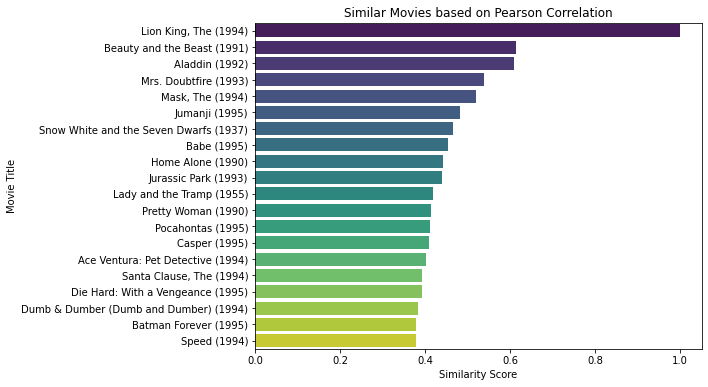

In [20]:
recommender('lion king', dense_matrix_movies_users, knn, 20)